### 📦 Imports and Simulation Setup

This block imports necessary libraries, downloads a food nutrition dataset from Kaggle, and defines the simulation time resolution:

- **Libraries**: `numpy`, `matplotlib`, `scipy` for math, plotting, and optimization.
- **Dataset**: Pulled via `kagglehub` for meal generation.
- **Simulation**: Runs for 24 hours with 10-minute steps (`time_vector` in minutes).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import random
import time
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utsavdey1410/food-nutrition-dataset")
print("Path to dataset files:", path)

# Simulation resolution: 1 step = 10 minutes
TIME_STEP_MIN = 10
SIM_HOURS = 24
SIM_STEPS = int((60 / TIME_STEP_MIN) * SIM_HOURS)

# Time vector (in minutes)
time_vector = np.arange(0, SIM_HOURS * 60, TIME_STEP_MIN)


Path to dataset files: /kaggle/input/food-nutrition-dataset


### Initial Physiological State and Parameters

This block defines the initial state of the simulated diabetic patient and the parameters governing glucose-insulin dynamics:

- `state`: Starting blood glucose and insulin levels.
- `params`: Physiological constants:
  - `Gb`: Baseline glucose (elevated for diabetic simulation).
  - `p1`: Glucose decay rate (non-insulin-dependent clearance).
  - `p3`: Insulin sensitivity (how strongly insulin lowers glucose).
- `history`: A dictionary to log time-series data for plotting later.


In [2]:
# Initial physiological state
state = {
    'glucose': 100.0,   # mg/dL
    'insulin': 0.0,     # mU/L
}

# Glucose regulation parameters
params = {
    'Gb': 120.0,        # Baseline glucose
    'Ib': 0.0,         # Baseline insulin
    'p1': 0.003,       # Glucose decay rate
    'p2': 0.02,        # Insulin decay rate
    'p3': 0.01,        # Insulin action gain
}

# Logging for results
history = {
    'time': [],
    'glucose': [],
    'insulin': [],
    'meals': [],
    'doses': []
}


### Meal Dataset Processing and Clustering

This block loads and prepares nutritional data from multiple CSV files, then clusters meals by nutritional profile:

- **Load & clean**: Merges 5 food group CSVs and selects key columns.
- **Normalize**: Standardizes nutrient values for clustering.
- **Cluster**: Groups meals into 3 types (`healthy`, `balanced`, `cheat`) using KMeans based on caloric value.
- **Catalog**: Creates a pool of meals categorized by type, with a default digestion duration of 120 minutes.

These meals will later be randomly selected to simulate daily eating behavior.


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Reload all food group CSVs
group_files = [
    "FOOD-DATA-GROUP1.csv",
    "FOOD-DATA-GROUP2.csv",
    "FOOD-DATA-GROUP3.csv",
    "FOOD-DATA-GROUP4.csv",
    "FOOD-DATA-GROUP5.csv"
]

dfs = [pd.read_csv(f"/content/{file}") for file in group_files]
food_data = pd.concat(dfs, ignore_index=True)

# Select and clean up columns
selected_cols = ['food', 'Carbohydrates', 'Protein', 'Fat', 'Sodium', 'Caloric Value']
meal_df = food_data[selected_cols].dropna().reset_index(drop=True)

# Normalize nutritional data
X = meal_df[['Carbohydrates', 'Protein', 'Fat', 'Sodium', 'Caloric Value']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster into 3 meal types
kmeans = KMeans(n_clusters=3, random_state=42)
meal_df['cluster'] = kmeans.fit_predict(X_scaled)

# Assign labels to clusters based on calorie means
cluster_means = meal_df.groupby('cluster')['Caloric Value'].mean().sort_values()
cluster_to_label = {
    cluster_means.index[0]: 'healthy',
    cluster_means.index[1]: 'balanced',
    cluster_means.index[2]: 'cheat'
}

meal_df['meal_type'] = meal_df['cluster'].map(cluster_to_label)

# Create final categorized meal pools
healthy_meals = meal_df[meal_df['meal_type'] == 'healthy'].to_dict(orient='records')
balanced_meals = meal_df[meal_df['meal_type'] == 'balanced'].to_dict(orient='records')
cheat_meals = meal_df[meal_df['meal_type'] == 'cheat'].to_dict(orient='records')
meal_catalog = healthy_meals + balanced_meals + cheat_meals

# Add default digestion-related fields if missing
for meal in meal_catalog:
    meal["duration"] = meal.get("duration", 120)  # default: 2 hours (120 min)


active_meals = []


### Meal Scheduling and Selection Logic

This block defines when meals can occur, how they’re selected, and how food cravings affect cheat meal likelihood.

- `in_sleep_hours`: Prevents meals during sleep (10:00 PM – 6:00 AM).
- `realistic_meal_time`: Allows meals at standard breakfast, lunch, and dinner windows, with some flexibility.
- `pick_meal_by_type`: Filters out non-meal items (like oils, powders), avoids duplicates, and optionally combines smaller meals.
- `generate_meal_event`: Handles timing and nutritional constraints to decide if a meal should be consumed at the current step.
- `select_meal_with_craving`: Adds behavioral realism by favoring cheat meals based on time since the last one and a “fun” score.


In [4]:
last_meal_time = -1000  # minutes
sleep_start = 1320  # 10:00 PM
sleep_end = 360     # 6:00 AM

def in_sleep_hours(current_time):
    hour = current_time % 1440
    return hour >= sleep_start or hour < sleep_end

def realistic_meal_time(current_time):
    hour = current_time % 1440
    if 360 <= hour < 600:
        return True
    if 720 <= hour < 840:
        return True
    if 1080 <= hour < 1200:
        return True
    if 900 <= hour < 1020:
        return random.random() < 0.3
    return False

def pick_meal_by_type(meal_type):
    if meal_type == "healthy":
        pool = [m for m in healthy_meals if m["food"] not in meals_today]
    elif meal_type == "balanced":
        pool = [m for m in balanced_meals if m["food"] not in meals_today]
    else:
        pool = [m for m in cheat_meals if m["food"] not in meals_today]

    ban_keywords = [
        "flour", "oil", "syrup", "powder", "shortening", "spread", "sweetener",
        "extract", "dressing", "icing", "frosting", "mix", "butter", "salt", "fat"
    ]
    pool = [m for m in pool if not any(bad in m["food"].lower() for bad in ban_keywords)]

    filtered = [m for m in pool if m["Caloric Value"] > 100 and m["food"] not in meals_today]

    if not filtered:
        filtered = [m for m in pool if m["food"] not in meals_today]

    if not filtered:
        return random.choice(meal_catalog)

    chosen = random.choice(filtered)

    # Combine if small
    if chosen["Caloric Value"] < 350:
        complement_pool = [
            m for m in filtered if m["food"] != chosen["food"] and
            m["Caloric Value"] + chosen["Caloric Value"] <= 700
        ]
        if complement_pool:
            combo = [chosen, random.choice(complement_pool)]
            combined = {
                "food": " + ".join(m["food"] for m in combo),
                "Caloric Value": sum(m["Caloric Value"] for m in combo),
                "Protein": sum(m["Protein"] for m in combo),
                "Fat": sum(m["Fat"] for m in combo),
                "Sodium": sum(m["Sodium"] for m in combo),
                "Carbohydrates": sum(m.get("Carbohydrates", 0) for m in combo),
                "hydration_impact": sum(m.get("hydration_impact", 0) for m in combo),
                "bp_impact": sum(m.get("bp_impact", 0) for m in combo),
                "glycemic_index": sum(m.get("glycemic_index", 55) for m in combo) / len(combo),
                "duration": max(m.get("duration", 120) for m in combo),
            }
            meals_today.add(combo[0]["food"])
            meals_today.add(combo[1]["food"])
            return combined

    meals_today.add(chosen["food"])
    return chosen


def generate_meal_event(current_time):
    global last_cheat_time, last_meal_time, total_calories_today
    global meal_count_today, meals_today
    global calories_consumed, protein_consumed, cheat_meal_eaten_today

    if meal_count_today >= 3:
        return None
    if in_sleep_hours(current_time):
        return None
    if current_time - last_meal_time < 180:
        return None

        calories = meal["Caloric Value"] * portion_multiplier
        protein = meal["Protein"] * portion_multiplier

        if not cheat_meal_eaten_today and calories_consumed + calories > 2500:
            return None

        active_meals.append({"meal": meal, "start_time": current_time})
        print(f"Meal at t={current_time} min: {meal['food']} ({calories:.0f} kcal, {protein:.0f}g protein, x{portion_multiplier:.2f})")

        calories_consumed += calories
        protein_consumed += protein

        if meal_type == "cheat":
            cheat_meal_eaten_today = True

        total_calories_today += calories
        meal_count_today += 1
        meals_today.add(meal["food"])
        last_meal_time = current_time
        return meal["food"]

    return None

last_cheat_time = -1000
CHEAT_FUN_THRESHOLD = 9

def compute_craving_bonus(current_time):
    time_since_last_cheat = max(0, current_time - last_cheat_time)
    return 1 + (time_since_last_cheat / 600)

def select_meal_with_craving(current_time):
    craving_factor = compute_craving_bonus(current_time)
    eligible_meals = [m for m in meal_catalog if m["food"] not in meals_today]
    if not eligible_meals:
        return random.choice(meal_catalog)

    scored_meals = []
    for meal in eligible_meals:
        fun_score = meal.get("fun", 5)
        gly_load = meal.get("carbs", 0) * meal.get("glycemic_index", 55) / 100
        bp = meal.get("bp_impact", 0)
        score = (fun_score * craving_factor) - 0.8 * gly_load - 2 * bp
        scored_meals.append((meal, score))

    scored_meals.sort(key=lambda x: x[1], reverse=True)
    top_meals = scored_meals[:3]
    chosen = random.choice(top_meals)[0]
    meals_today.add(chosen["food"])
    return chosen


### Glucose-Insulin Dynamics: `simulate_step()`

This function updates the physiological state over one simulation step.

- **Meal absorption (`D`)**: Adds glucose based on glycemic load and time since meal. Absorption is modeled using a bell-shaped Gaussian function.
- **Insulin dynamics (`I`)**: Includes dose plus 10% decay per step.
- **Insulin action (`X`)**: Scaled by insulin effectiveness and sensitivity (`p3`).
- **Liver glucose production**: Adds glucose if blood sugar drops below 100 mg/dL.
- **Glucose rate of change (`dGdt`)**: Accounts for natural decay, insulin action, meal input, and hepatic output.
- **Returns**: The new glucose and insulin levels for the next step.


In [5]:
def simulate_step(state, dose, current_time, prev_glucose):
    D = 0  # Glucose absorbed from meals
    insulin_effectiveness = 0.25  # (was 0.3–0.5 for normal)

    for m in active_meals:
        t_diff = current_time - m["start_time"]
        duration = m["meal"].get("duration", 120)
        if 0 <= t_diff <= duration:
            carbs = m["meal"].get("Carbohydrates", 0)
            gi = m["meal"].get("glycemic_index", 55)
            gly_load = carbs * gi / 100
            # Smooth absorption: higher in middle of window, tapers at ends
            absorption = gly_load * 0.08 * np.exp(-((t_diff - duration/2) ** 2) / (2 * (duration/5)**2))
            D += absorption


    G = state['glucose']
    I = state['insulin'] * 0.90 + dose  # decay + current dose
    X = insulin_effectiveness * params['p3'] * (I + 1.0)

    # Simulate liver glucose production if glucose is low
    liver_production = 0.05 * max(0, 100 - G)

    # Updated glucose change equation
    dGdt = -params['p1'] * (G - params['Gb']) - X * (G - params['Gb']) + D + liver_production

    new_state = {
        'glucose': G + dGdt,
        'insulin': max(0.0, I * 0.90),  # slower decay
    }

    # Add meal glucose input
    # Time-based glucose absorption (simulate digestion curve)
    D = 0
    for meal in active_meals:
        minutes_since_meal = current_time - meal['start_time']
        if 0 <= minutes_since_meal <= 120:
            carbs = meal['meal'].get('Carbohydrates', 0)
            # Smooth absorption using cosine decay from t=0 to t=120
            absorption_fraction = 0.5 * (1 - np.cos(np.pi * minutes_since_meal / 120))
            D += carbs * absorption_fraction * 1.0  # 1.0 is scaling factor

    print(f"Glucose={G:.1f} | Liver output={liver_production:.2f}")

    return new_state


### Insulin Dose Optimization: `optimize_dose()`

This function computes the ideal insulin dose at each time step using numerical optimization.

- **Objective**: Minimize deviation from target glucose (100 mg/dL) while avoiding large or unstable corrections.
- **Terms in cost function**:
  - `glucose_deviation`: Penalizes distance from the target.
  - `penalty`: Penalizes large insulin doses.
  - `stability_penalty`: Discourages abrupt glucose changes compared to the previous step.
- **Output**: Optimal insulin dose (bounded between 0 and 10 units) returned by `scipy.optimize.minimize`.


In [6]:
from scipy.optimize import minimize

def optimize_dose(state, prev_glucose):
    def objective(u):
        predicted_glucose = state['glucose'] - 10 * u[0]  # adjust sensitivity if needed
        glucose_deviation = (predicted_glucose - 100)**2  # goal: bring toward 100
        penalty = 0.1 * u[0]**2  # penalize large doses
        stability_penalty = 2.0 * abs(predicted_glucose - prev_glucose)  # discourage big swings
        return glucose_deviation + penalty + stability_penalty

    res = minimize(objective, [0.0], bounds=[(0.0, 10.0)])
    return res.x[0]


### Full Daily Simulation Loop

This block simulates glucose dynamics, meal events, and insulin dosing over a full day (24 hours in 10-minute steps).

- **Meal schedule**: Meals are allowed during typical breakfast, lunch, and dinner windows, with checks to prevent overeating or frequent meals.
- **Meal selection and scaling**:
  - Meals are chosen randomly by type (healthy, balanced, cheat).
  - Scaling adjusts portion size based on calorie and protein needs.
  - High-calorie or nutritionally unbalanced foods (e.g., standalone bread) are downscaled or skipped.
- **Meal rejection**: Meals are skipped if they're nutritionally insufficient or would exceed calorie thresholds.
- **Insulin dosing**:
  - Dosing is optimized only if glucose exceeds 115 mg/dL using the `optimize_dose()` function.
- **Simulation step**: Each time step advances glucose and insulin levels using `simulate_step()`.
- **Meal absorption**: Meals remain active for 120 minutes and are cleared afterward.
- **Logging**: Glucose, insulin, dose, and meals are stored at each step for analysis and plotting.


In [7]:
prev_glucose = state['glucose']
meal_count_today = 0
total_calories_today = 0
meals_today = set()

DAILY_CALORIE_TARGET = 2300
DAILY_PROTEIN_TARGET = 170

calories_consumed = 0
protein_consumed = 0
cheat_meal_eaten_today = False
last_meal_time = -1000

for t in time_vector:
    if t % 1440 == 0:  # New day
        meal_count_today = 0
        total_calories_today = 0
        meals_today = set()
        calories_consumed = 0
        protein_consumed = 0
        cheat_meal_eaten_today = False
        last_meal_time = -1000

    # Meal timing: breakfast, lunch, dinner windows
    hour = t % 1440
    if 360 <= hour <= 600 or 720 <= hour <= 840 or 1080 <= hour <= 1200:
        if t - last_meal_time >= 240 and meal_count_today < 4:
            meal_type = random.choices(["healthy", "balanced", "cheat"], weights=[0.5, 0.4, 0.1])[0]
            meal = pick_meal_by_type(meal_type)

            calories_raw = max(0, meal.get("Caloric Value", 0))
            protein_raw = max(0, meal.get("Protein", 0))

            if calories_raw > 0 and protein_raw > 0:
                cal_remaining = DAILY_CALORIE_TARGET - calories_consumed
                prot_remaining = DAILY_PROTEIN_TARGET - protein_consumed

                # Smart scaling
                # Only scale if it's not a standalone starch/carb
                if (protein_raw < 15 or calories_raw < 300) and not any(kw in meal['food'].lower() for kw in ['bread', 'roti', 'rice', 'chapatti', 'noodle', 'pasta']):
                    portion_multiplier = min(
                        max(1.0, prot_remaining / protein_raw),
                        max(1.0, cal_remaining / calories_raw),
                        2.0
                    )
                elif calories_raw > 800:
                    portion_multiplier = min(0.6, cal_remaining / calories_raw)  # cap heavy meals
                else:
                    portion_multiplier = 1.0

                portion_multiplier = max(0.4, min(portion_multiplier, 2.0))

                calories = calories_raw * portion_multiplier
                protein = protein_raw * portion_multiplier

                # Reject absurdly large meals even if scaled
                if calories > 1000:
                    meal_name = None
                    continue  # skip this time step


                if calories >= 120 and protein >= 10:
                    if not cheat_meal_eaten_today and calories_consumed + calories > 2500:
                        meal_name = None
                    else:
                        active_meals.append({"meal": meal, "start_time": t})
                        meal_name = f"{meal['food']} ({calories:.0f} kcal, {protein:.0f}g protein, x{portion_multiplier:.2f})"
                        print(f"\n🍽️ Meal at t={t} min: {meal_name}")
                        print(f"   → Glucose before: {state['glucose']:.2f} mg/dL")
                        print(f"   → Insulin before: {state['insulin']:.2f} mU/L")
                        print(f"Meal at t={t} min: {meal_name}")

                        calories_consumed += calories
                        protein_consumed += protein
                        if meal_type == "cheat":
                            cheat_meal_eaten_today = True

                        total_calories_today += calories
                        meal_count_today += 1
                        meals_today.add(meal["food"])
                        last_meal_time = t
                else:
                    meal_name = None
            else:
                meal_name = None
        else:
            meal_name = None
    else:
        meal_name = None

    # Insulin correction dose
    if state['glucose'] > 115:
        dose = optimize_dose(state, prev_glucose)
    else:
        dose = 0.0

    # Simulate
    new_state = simulate_step(state, dose, t, prev_glucose)

    if meal_name:
        print(f"🍽️ t={t} | Meal: {meal_name} | Glucose={state['glucose']:.1f} mg/dL | Dose={dose:.2f}u")

    prev_glucose = state['glucose']
    state = new_state

    # After simulate_step in your loop:
    active_meals = [m for m in active_meals if t - m['start_time'] <= 120]


    # Log
    history['time'].append(t)
    history['glucose'].append(state['glucose'])
    history['insulin'].append(state['insulin'])
    history['doses'].append(dose)
    history['meals'].append(meal_name)


Glucose=100.0 | Liver output=0.00
Glucose=100.1 | Liver output=0.00
Glucose=100.2 | Liver output=0.00
Glucose=100.3 | Liver output=0.00
Glucose=100.4 | Liver output=0.00
Glucose=100.5 | Liver output=0.00
Glucose=100.7 | Liver output=0.00
Glucose=100.8 | Liver output=0.00
Glucose=100.9 | Liver output=0.00
Glucose=101.0 | Liver output=0.00
Glucose=101.1 | Liver output=0.00
Glucose=101.2 | Liver output=0.00
Glucose=101.3 | Liver output=0.00
Glucose=101.4 | Liver output=0.00
Glucose=101.5 | Liver output=0.00
Glucose=101.6 | Liver output=0.00
Glucose=101.7 | Liver output=0.00
Glucose=101.8 | Liver output=0.00
Glucose=101.9 | Liver output=0.00
Glucose=102.0 | Liver output=0.00
Glucose=102.1 | Liver output=0.00
Glucose=102.2 | Liver output=0.00
Glucose=102.3 | Liver output=0.00
Glucose=102.4 | Liver output=0.00
Glucose=102.5 | Liver output=0.00
Glucose=102.6 | Liver output=0.00
Glucose=102.7 | Liver output=0.00
Glucose=102.8 | Liver output=0.00
Glucose=102.9 | Liver output=0.00
Glucose=103.0 

### Plotting Glucose and Insulin Over Time

This block visualizes the results of the simulation:

- **Glucose curve (blue)**: Tracks blood glucose levels throughout the day.
- **Insulin curve (green)**: Shows the optimizer-controlled insulin doses.
- **Meal markers**:
  - Vertical dashed lines indicate when meals occurred.
  - Meal names are labeled at the top of the plot for context.
- **Axes and styling**: Time is in minutes; values represent glucose (mg/dL) and insulin (units). Grid and legend are included for clarity.


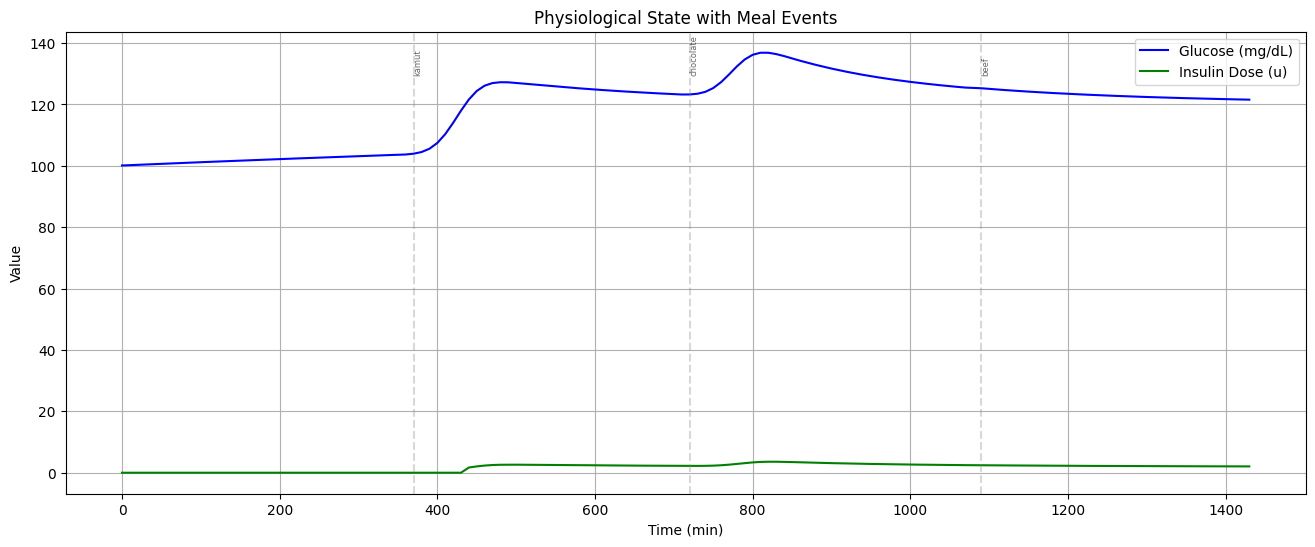

In [8]:
plt.figure(figsize=(16,6))
plt.plot(history['time'], history['glucose'], label='Glucose (mg/dL)', color='blue')
plt.plot(history['time'], history['doses'], label='Insulin Dose (u)', color='green')

# Add meal markers
for i, meal in enumerate(history['meals']):
    if meal:
        plt.axvline(x=history['time'][i], linestyle='--', color='gray', alpha=0.3)
        plt.text(history['time'][i], 130, meal.split()[0], rotation=90, fontsize=6, alpha=0.6)


plt.title("Physiological State with Meal Events")
plt.xlabel("Time (min)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
